In [5]:
%matplotlib inline
import daft
import pymc
import matplotlib.pyplot as plt
import matplotlib as mlp
import numpy as np
import ggplot
import pandas as pd

COLORS = ["#348ABD", "#A60628", "#7A68A6"]

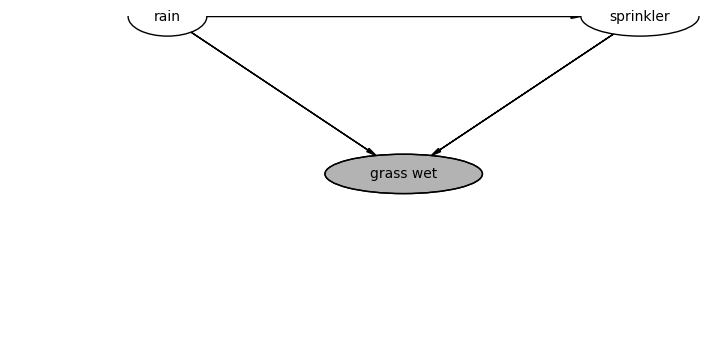

In [24]:
pgm = daft.PGM([9, 4], origin=[1, 0.5])
pgm.add_node(daft.Node('r', 'rain', 3, 4, aspect=2))
pgm.add_node(daft.Node('s', 'sprinkler', 9, 4, aspect=3))
pgm.add_node(daft.Node('w', 'grass wet', 6, 2, aspect=4, observed=True))
pgm.add_edge('r', 's')
pgm.add_edge('r', 'w')
pgm.add_edge('s', 'w')
pgm.render()

In [5]:
from IPython.display import Image
Image(url='http://upload.wikimedia.org/wikipedia/commons/0/0e/SimpleBayesNet.svg')

In [45]:
# Initialization
observed_values = [1.]

rain = pymc.Bernoulli('rain', .2, value=np.ones(len(observed_values)))

p_sprinkler = pymc.Lambda('p_sprinkler', lambda rain=rain: np.where(rain, .01, .4))

# "Real" sprinkler varible
sprinkler = pymc.Bernoulli('sprinkler', p_sprinkler, value=np.ones(len(observed_values)))

p_grass_wet = pymc.Lambda('p_grass_wet', lambda sprinkler=sprinkler, rain=rain: np.where(sprinkler, np.where(rain, .99, .9), 
                                                                                         np.where(rain, .8, 0.2)))
grass_wet = pymc.Bernoulli('grass_wet', p_grass_wet, value=observed_values, observed=True)

model = pymc.Model([grass_wet, p_grass_wet, sprinkler, p_sprinkler, rain])

graph = pymc.graph.graph(model)
graph.write_png("graph.png")

True

In [46]:
## Inference
mcmc = pymc.MCMC(model)
mcmc.sample(10000, 2000)

 [-----------------100%-----------------] 10000 of 10000 complete in 1.5 sec

In [47]:
trace_r = mcmc.trace('rain')[:]
trace_p_sprinkler = mcmc.trace('p_sprinkler')[:]
trace_sprinkler = mcmc.trace('sprinkler')[:]
trace_p_grass_wet = mcmc.trace('p_grass_wet')[:]

Plotting p_grass_wet_0
Plotting rain_0
Plotting sprinkler_0
Plotting p_sprinkler_0


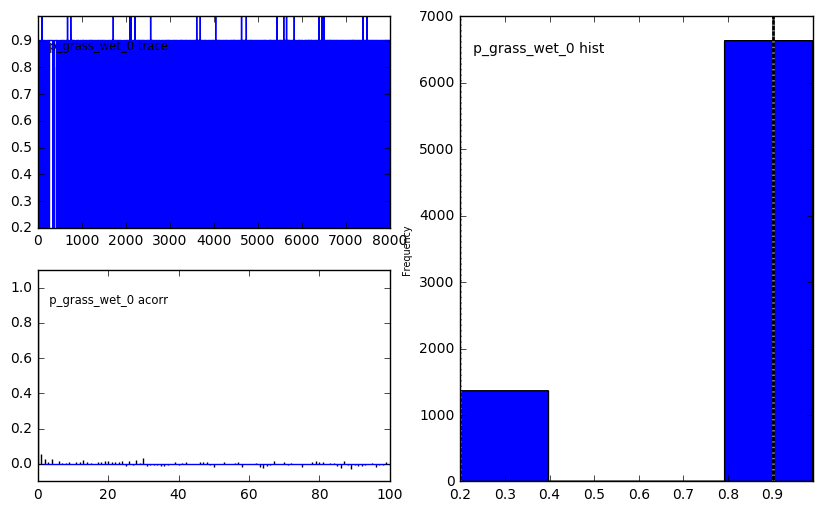

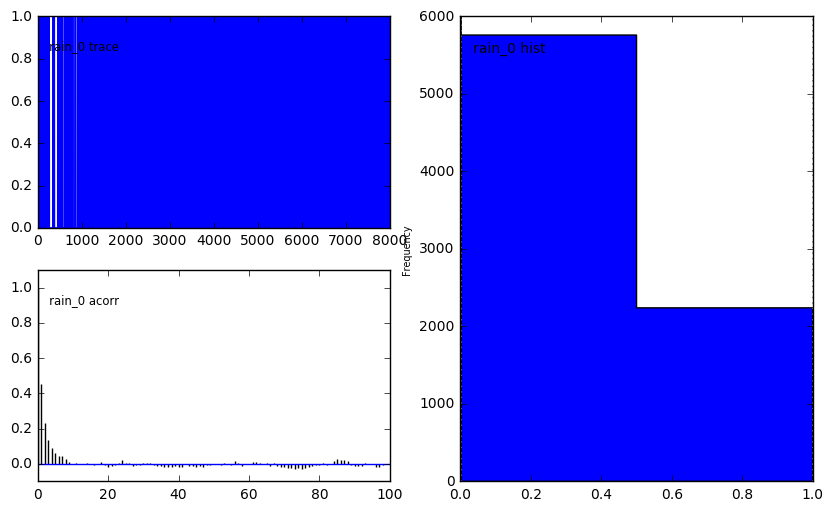

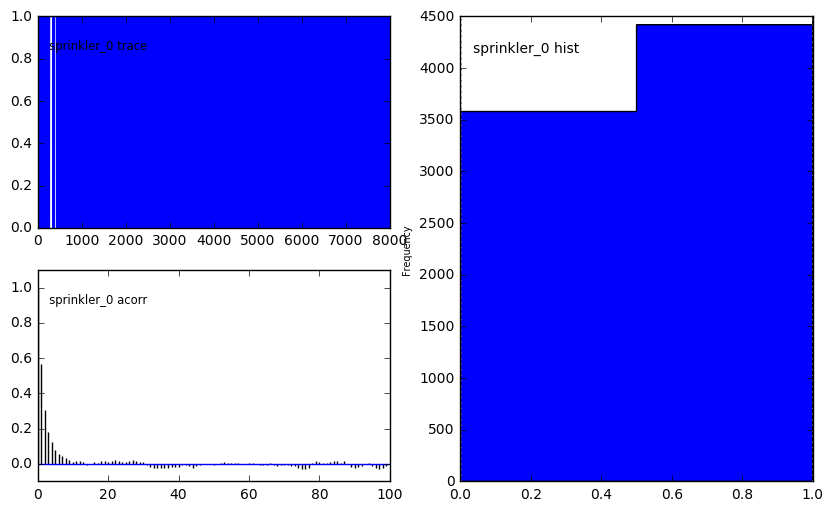

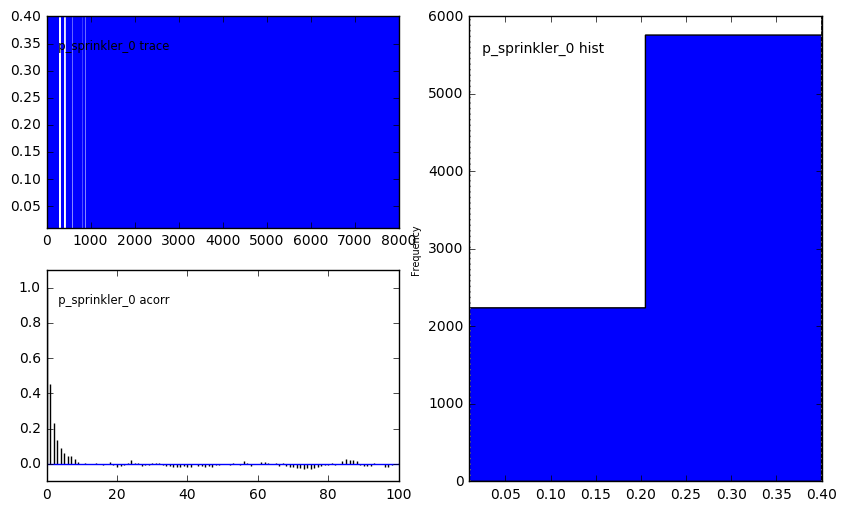

In [59]:
# Convergence diagnostic
pymc.Matplot.plot(mcmc)

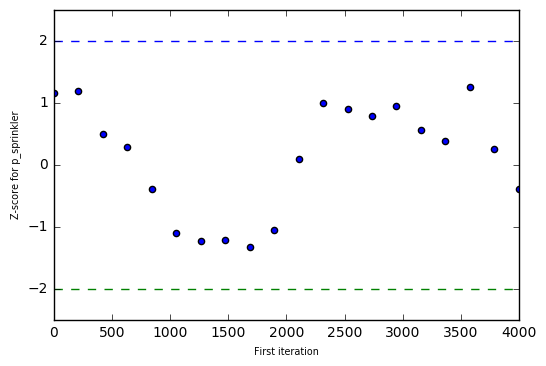

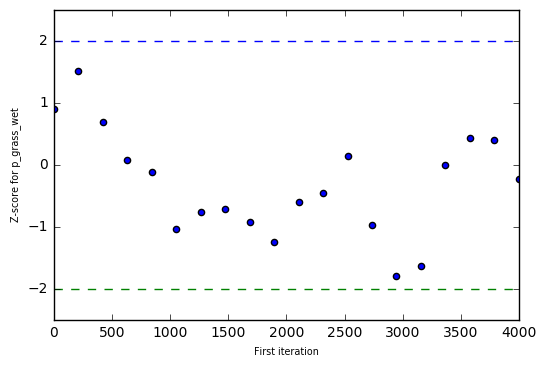

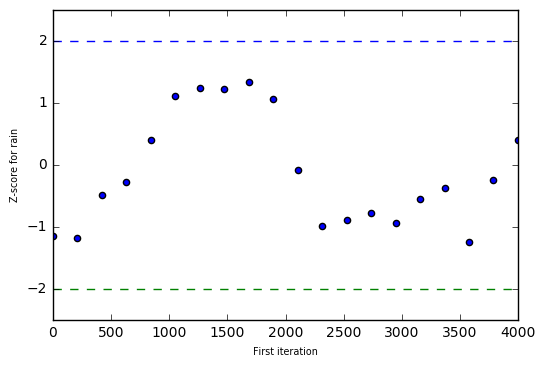

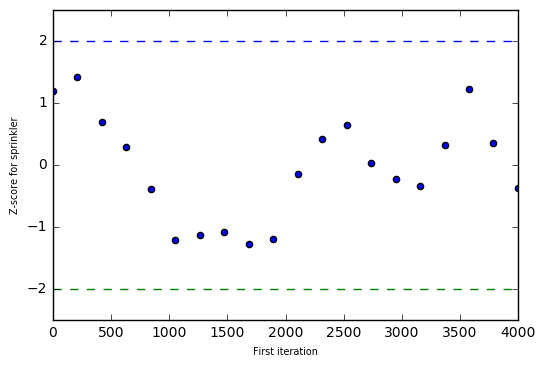

In [48]:
geweke = pymc.geweke(mcmc)
pymc.Matplot.geweke_plot(geweke)

In [60]:
print len(trace_r.tolist())
dictionary = {
              'Rain': [1 if ii[0] else 0 for ii in trace_r.tolist() ],
              'Sprinkler': [1 if ii[0] else 0 for ii in trace_sprinkler.tolist() ],
              'Sprinkler Probability': [ii[0] for ii in trace_p_sprinkler.tolist()],
              'Grass Wet': [ii[0] for ii in trace_p_grass_wet.tolist()],
              }
df = pd.DataFrame(dictionary)
print df
df.head()

8000
      Grass Wet  Rain  Sprinkler  Sprinkler Probability
0           0.8     1          0                   0.01
1           0.8     1          0                   0.01
2           0.2     0          0                   0.40
3           0.2     0          0                   0.40
4           0.9     0          1                   0.40
5           0.2     0          0                   0.40
6           0.2     0          0                   0.40
7           0.8     1          0                   0.01
8           0.8     1          0                   0.01
9           0.8     1          0                   0.01
10          0.8     1          0                   0.01
11          0.2     0          0                   0.40
12          0.8     1          0                   0.01
13          0.8     1          0                   0.01
14          0.8     1          0                   0.01
15          0.8     1          0                   0.01
16          0.8     1          0           

,Grass Wet,Rain,Sprinkler,Sprinkler Probability
0,0.8,1,0,0.01
1,0.8,1,0,0.01
2,0.2,0,0,0.40
3,0.2,0,0,0.40
4,0.9,0,1,0.40


In [53]:
print len(trace_r.tolist())
dictionary = {
              'Rain': [1 if ii[0] else 0 for ii in trace_r.tolist() ],
              'Sprinkler Probability': [ii[0] for ii in trace_p_sprinkler.tolist()],
              'Sprinkler': [1 if ii[0] else 0 for ii in trace_sprinkler.tolist() ],
              'Grass Wet': [ii[0] for ii in trace_p_grass_wet.tolist()],
              }
df = pd.DataFrame(dictionary)
df.head()

8000


,Grass Wet,Rain,Sprinkler,Sprinkler Probability
0,0.8,1,0,0.01
1,0.8,1,0,0.01
2,0.2,0,0,0.40
3,0.2,0,0,0.40
4,0.9,0,1,0.40


In [77]:
# Given grass is wet, what is the probability that it was rained?
# print ((df['Rain'] == 1) & (df['Grass Wet'] > 0.5))
print df[(df['Rain'] == 1) & (df['Grass Wet'] > 0.5)].shape[0]
print df[df['Grass Wet'] > 0.5].shape[0] 
p_rain_wet = float(df[(df['Rain'] == 1) & (df['Grass Wet'] > 0.5)].shape[0]) / df[df['Grass Wet'] > 0.5].shape[0] 
print(p_rain_wet)

2240
6635
0.337603617182


In [13]:
# Given grass is wet, what is the probability that sprinkler was opened?
p_sprinkler_wet = float(df[df['Sprinkler'] == 1].shape[0]) / df[df['Grass Wet'] > 0.5].shape[0] 
print(p_sprinkler_wet)

0.651099317665


In [14]:
# Case where sprinkler did not work and it did not rain
p_not_sprinkler_rain_wet = float(df[(df['Sprinkler'] == 0) & (df['Rain'] == 0)].shape[0]) / df[df['Grass Wet'] > 0.5].shape[0] 
print(p_not_sprinkler_rain_wet)


0.213040181956


0       False
1       False
2       False
3       False
4        True
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20       True
21       True
22       True
23       True
24       True
25       True
26       True
27       True
28       True
29      False
        ...  
7970     True
7971    False
7972     True
7973     True
7974    False
7975    False
7976     True
7977     True
7978    False
7979     True
7980     True
7981     True
7982     True
7983     True
7984    False
7985     True
7986     True
7987     True
7988    False
7989    False
7990    False
7991     True
7992     True
7993    False
7994    False
7995    False
7996    False
7997     True
7998     True
7999    False
Name: Grass Wet, dtype: bool
